In [13]:
import FLOWMath
include("src/CCBlade.jl")
import .CCBlade

using Plots#; plotlyjs()

In [14]:
chord = 0.2
theta = 0.0
Rtip  = 2.
Rhub  = 0.0
B     = 3
Omega = 2000*pi/30

rho = 1.225
A   = pi*(Rtip^2 - Rhub^2) # pi*Rtip^2

r    = collect(range(Rhub, Rtip, length=20))

af       = CCBlade.SimpleAF(2*pi, 0., 100.0, -100., 0.02, 0.)
rotor    = CCBlade.Rotor(Rhub, Rtip, B, tip=nothing)
sections = CCBlade.Section.(r, chord, theta, Ref(af));
dA_A     = pi.*(sections.r.^2 .- rotor.Rhub^2)./A;

In [15]:
function axial(pitch, Vc, Omega, rho, rotor, sections)
    op   = CCBlade.simple_op.(Vc, Omega, sections.r, rho, pitch=pitch)
    out  = CCBlade.solve.(Ref(rotor), sections, op, force_momentum=true)
    T, Q = CCBlade.thrusttorque(rotor, sections, out)
    
    Vh = sqrt(abs(T)/(2*rho*A))
    if sign(T)*Vc/Vh < -1.5
        out  = CCBlade.solve.(Ref(rotor), sections, op)
        T, Q = CCBlade.thrusttorque(rotor, sections, out)
    end
    
    P  = Q*Omega
    Vi = FLOWMath.trapz(dA_A, out.u)
    a  = FLOWMath.trapz(dA_A, out.a)

    return T, P, Vi, a, out.a, out.u
end

function axial_thrust(thrust, Vc, Omega, rho, rotor, sections)
    pitch, verbose = FLOWMath.brent(pitch -> thrust - axial(pitch, Vc, Omega, rho, rotor, sections)[1], -45*pi/180, 45*pi/180)
    T, P, Vi, a, a_full, u_full = axial(pitch, Vc, Omega, rho, rotor, sections)

    return pitch, P, Vi, a, verbose, a_full, u_full
end

axial_thrust (generic function with 1 method)

In [16]:
# Johnson's inflow model (quartic fit through Vortex Ring State and Turbulent Wake State)
function Solve_Inflow(lambda_h, mu, mu_z) # (CT, mu, mu_z)
    # lambda_h = sqrt(CT/2);
    
    if 1.5*mu^2 + (2*mu_z + 3*lambda_h)^2 < lambda_h^2
        # Approximation for turbulent-wake and vortex-ring states
        lambda = mu_z*(((0.373*mu_z^2 + 0.598*mu^2)/lambda_h^2) - 0.991)
    else
        # Newton-Raphson solution w/ relaxation factor
        lambda = mu_z + lambda_h^2/sqrt((lambda_h + mu_z)^2 + mu^2)
        relax = 0.5
        err = 1
        while err > 1e-6
            lambda_old   = lambda
            lambda_i_old = lambda_h^2/sqrt(lambda_old^2 + mu^2)
            lambda       = lambda_old - relax*((lambda_old - mu_z - lambda_i_old)/(1 + lambda_i_old*lambda_old/(lambda_old^2 + mu^2)))
            
            err = abs(lambda - lambda_old)
        end
    end
    return lambda - mu_z # lambda
end

Solve_Inflow (generic function with 1 method)

In [17]:
# Hover
T_h, P_h, _, a_h, a_full_h, u_full_h = axial(13*pi/180, 0., Omega, rho, rotor, sections);
V_h = sqrt(abs(T_h)/(2*rho*A))

lambda_h = V_h/(Omega*Rtip);

In [18]:
lambda_c_lambda_h = range(-5,3,501)
# lambda_c_lambda_h = [-2.5, -2., -1.5, -1.0, -0.5]
# lambda_c_lambda_h = range(-1.75,-1.64,2)

# Get Johnson's solution
lambda_i_lambda_h = Solve_Inflow.(lambda_h, 0., lambda_c_lambda_h.*lambda_h)./lambda_h;

# CCBlade.jl solution
Vc = lambda_c_lambda_h.*V_h
Vi = similar(Vc)
P  = similar(Vc)
a  = similar(Vc)
a_full  = Matrix{Float64}(undef, length(sections.r), length(Vc))
u_full  = Matrix{Float64}(undef, length(sections.r), length(Vc))

for i in 1:lastindex(Vc)
    pitch, P[i], Vi[i], a[i], verbose, a_full[:,i], u_full[:, i] = axial_thrust(T_h, Vc[i], Omega, rho, rotor, sections)
    # println("====================================================================================")
    # @show Vc[i]/V_h, pitch*180/pi, verbose[3]
end

In [19]:
# Leishman's
k1 = -1.125
k2 = -1.372
k3 = -1.718
k4 = -0.655

Vc_Vh = range(-2, 0, 101)
Vi_Vh = @. 1. + k1*Vc_Vh + k2*Vc_Vh^2 + k3*Vc_Vh^3 + k4*Vc_Vh^4;

In [20]:
# Might be something to do with this

a_end = -1.15175 # at Vc_Vh = -1.5

-1.15175

In [21]:
a_end / (1 + a_end)

7.589785831960459

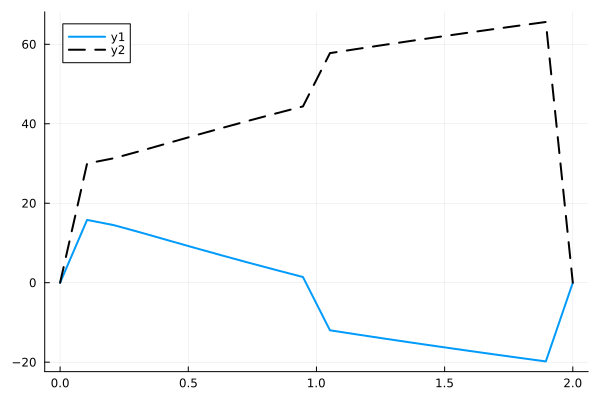

In [22]:
idx = 220#length(Vc)
plot(sections.r, u_full[:, idx], linewidth=2)
plot!(sections.r, a_full[:, idx].*Vc[idx], linewidth=2, linestyle=:dash, color=:black)

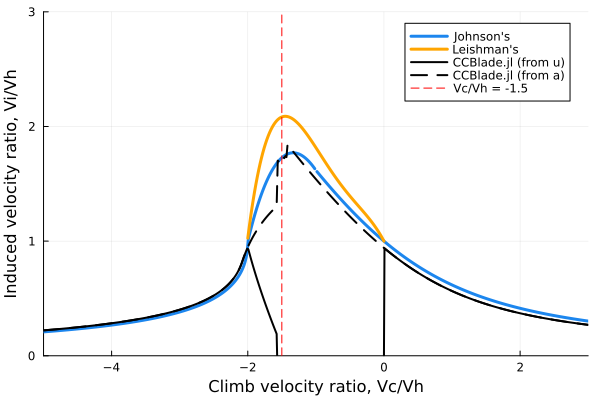

In [23]:
plot(lambda_c_lambda_h, lambda_i_lambda_h, color=:dodgerblue2, linewidth=3, label="Johnson's")
plot!(Vc_Vh, Vi_Vh, color=:orange, linewidth=3, label="Leishman's")
plot!(Vc./V_h, Vi./V_h, color=:black, linewidth=2, label="CCBlade.jl (from u)")
plot!(Vc./V_h, a.*Vc./V_h, color=:black, linestyle=:dash, linewidth=2, label="CCBlade.jl (from a)")
plot!([-1.5, -1.5], [0, 3], color=:red, linestyle=:dash, label="Vc/Vh = -1.5")
# scatter!(Vc[a.>=-0.4]./V_h, a[a.>=-0.4].*Vc[a.>=-0.4]./V_h, color=:green, label="CCBlade.jl (momentum)")
# scatter!(Vc[(a.>-1) .& (a.<-0.4)]./V_h, a[(a.>-1) .& (a.<-0.4)].*Vc[(a.>-1) .& (a.<-0.4)]./V_h, color=:cyan, label="CCBlade.jl (empirical)")
# scatter!(Vc[a.<=-1]./V_h, a[a.<=-1].*Vc[a.<=-1]./V_h, color=:red, label="CCBlade.jl (VRS)")
xlims!(-5,3)
ylims!(0,3)
xlabel!("Climb velocity ratio, Vc/Vh")
ylabel!("Induced velocity ratio, Vi/Vh")

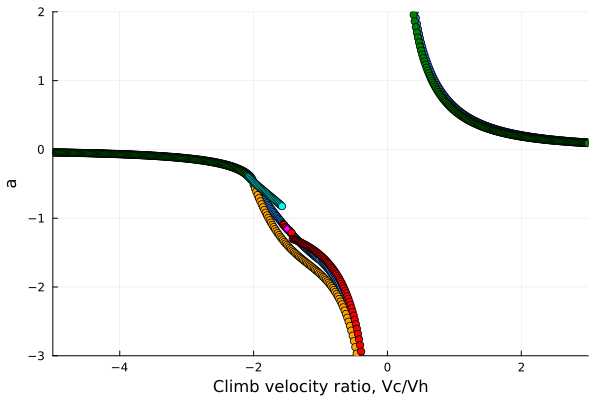

In [24]:
scatter(lambda_c_lambda_h, lambda_i_lambda_h./lambda_c_lambda_h, color=:dodgerblue2, label="Johnson's")
scatter!(Vc_Vh, Vi_Vh./Vc_Vh, color=:orange, linewidth=3, label="Leishman's")
scatter!(Vc[a.>=-0.4]./V_h, a[a.>=-0.4], color=:green, linewidth=2, label="CCBlade.jl (momentum)")
scatter!(Vc[(a.>-1) .& (a.<-0.4)]./V_h, a[(a.>-1) .& (a.<-0.4)], color=:cyan, linewidth=2, label="CCBlade.jl (empirical)")
scatter!(Vc[a.<=-1]./V_h, a[a.<=-1], color=:red, linewidth=2, label="CCBlade.jl (VRS)")
plot!(legend=:none)
scatter!([-1.5], [a_end], marker=:diamond, markercolor=:magenta)
xlims!(-5 ,3)
ylims!(-3, 2)
xlabel!("Climb velocity ratio, Vc/Vh")
ylabel!("a")